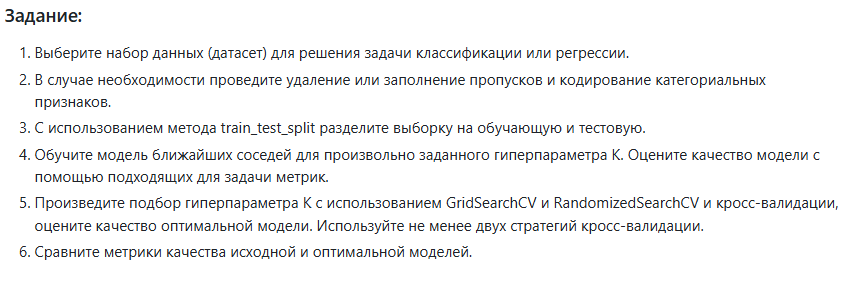


Dataset Link: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset/data

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv("gym_members_exercise_tracking.csv")
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [21]:
# Кодируем категориальные признаки 
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Workout_Type'] = label_encoder.fit_transform(df['Workout_Type'])
df['Experience_Level'] = label_encoder.fit_transform(df['Experience_Level'])

### Разделяем датасет

In [22]:
X = df.drop(['Experience_Level'], axis=1)
y_experience = df['Experience_Level']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_experience, test_size=0.2, random_state=42)
print('Train size:', X_train.shape[0])
print('Test_size:',X_test.shape[0])

Train size: 778
Test_size: 195


### Обучем базовую KNN

In [28]:
k_base = 3
knn_base = KNeighborsRegressor(n_neighbors=k_base)
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)

# Оценка качества
r2_base = r2_score(y_test, y_pred_base)
mse_base = mean_squared_error(y_test, y_pred_base)
rmse_base = np.sqrt(mse_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

print("r2_base: ", r2_base)
print("mse_base: ", mse_base)
print("rmse_base: ", rmse_base)
print("mae_base: ", mae_base)

r2_base:  0.5491012184823258
mse_base:  0.2621082621082621
rmse_base:  0.5119650985255363
mae_base:  0.3384615384615385


### Подбираем K

In [30]:
k_range = np.arange(1, 31)
param_search_grid = {'n_neighbors': k_range}

# Стратегии кросс-валидации
cv_k5 = KFold(n_splits=5, shuffle=True, random_state=52)
cv_k10 = KFold(n_splits=10, shuffle=True, random_state=52)
cv_loo = LeaveOneOut() # Оставим закомментированным, т.к. может быть долго

cv_strategies = {'KFold-5': cv_k5, 'KFold-10': cv_k10, 'LOO': cv_loo}
results = {}

# Используем GridSearchCV
print('Используем GridSearchCV\n')
for name, cv_method in cv_strategies.items():
    print(f"\n-- GridSearchCV, CV: {name} --")
    current_scoring = 'r2' if name != 'LOO' else 'neg_mean_squared_error' # добавили из-за loo
    search = GridSearchCV(KNeighborsRegressor(), param_search_grid, cv=cv_method, scoring=current_scoring, n_jobs=-1)
    search.fit(X_train, y_train)

    best_k = search.best_params_['n_neighbors']
    best_score_cv = search.best_score_

    # Оценка модели
    best_model = search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_best)
    mse_test = mean_squared_error(y_test, y_pred_best)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
    mae_test = mean_absolute_error(y_test, y_pred_best)

    results[f'GridSearch_{name}'] = {'k': best_k, 'r2_cv': best_score_cv, 'r2_test': r2_test, 'mse_test': mse_test, 'rmse_test': rmse_test, 'mae_test': mae_test}

    print("Лучший K: ", best_k)
    print(f"Лучший {current_scoring}: ", best_score_cv)
    print("R2: ", r2_test)
    print("RMSE: ", rmse_test)
    print("MAE: ", mae_test)

# Используем RandomizedSearchCV
print('Используем RandomizedSearchCV\n')
n_iterations = 20
param_random_dist = {'n_neighbors': k_range}

for name, cv_method in cv_strategies.items():
    print(f"\n-- RandomizedSearchCV, CV: {name} --")
    current_scoring = 'r2' if name != 'LOO' else 'neg_mean_squared_error' # добавили из-за loo
    search = RandomizedSearchCV(KNeighborsRegressor(), param_random_dist, n_iter=n_iterations,
                                cv=cv_method, scoring=current_scoring, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)

    best_k = search.best_params_['n_neighbors']
    best_score_cv = search.best_score_

    # Оценка модели
    best_model = search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_best)
    mse_test = mean_squared_error(y_test, y_pred_best)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
    mae_test = mean_absolute_error(y_test, y_pred_best)

    results[f'RandomSearch_{name}'] = {'k': best_k, 'r2_cv': best_score_cv, 'r2_test': r2_test, 'mse_test': mse_test, 'rmse_test': rmse_test, 'mae_test': mae_test}

    print("Лучший K: ", best_k)
    print(f"Лучший {current_scoring}: ", best_score_cv)
    print("R2: ", r2_test)
    print("RMSE: ", rmse_test)
    print("MAE: ", mae_test)

Используем GridSearchCV


-- GridSearchCV, CV: KFold-5 --
Лучший K:  16
Лучший r2:  0.5728644355894342
R2:  0.5780290402755157
RMSE:  0.4952700959564568
MAE:  0.36506410256410254

-- GridSearchCV, CV: KFold-10 --
Лучший K:  16
Лучший r2:  0.5691122713203086
R2:  0.5780290402755157
RMSE:  0.4952700959564568
MAE:  0.36506410256410254

-- GridSearchCV, CV: LOO --
Лучший K:  20
Лучший neg_mean_squared_error:  -0.23045308483290491
R2:  0.5621013165038002
RMSE:  0.5045307543166047
MAE:  0.37923076923076915
Используем RandomizedSearchCV


-- RandomizedSearchCV, CV: KFold-5 --
Лучший K:  16
Лучший r2:  0.5728644355894342
R2:  0.5780290402755157
RMSE:  0.4952700959564568
MAE:  0.36506410256410254

-- RandomizedSearchCV, CV: KFold-10 --
Лучший K:  16
Лучший r2:  0.5691122713203086
R2:  0.5780290402755157
RMSE:  0.4952700959564568
MAE:  0.36506410256410254

-- RandomizedSearchCV, CV: LOO --
Лучший K:  18
Лучший neg_mean_squared_error:  -0.2313942048303659
R2:  0.5664183455985844
RMSE:  0.50203763

### Сравним Метрики

In [31]:
base_metrics = {
    'k': k_base,
    'r2_test': r2_base,
    'rmse_test': rmse_base,
    'mae_test': mae_base
}
best_metrics_overall = base_metrics.copy()
best_model_origin = "Базовая модель"


for name, metrics_found in results.items():
    if metrics_found['r2_test'] > best_metrics_overall['r2_test']:
        best_metrics_overall = metrics_found.copy()
        best_model_origin = name

print("Результаты базовой модели")
print("r2:   ", r2_base)
print("mse:  ", mse_base)
print("rmse: ", rmse_base)
print("mae:  ", mae_base)

print(f"\nРезультаты лучшей модели: {best_model_origin}")
print("r2:   ", best_metrics_overall['r2_test'])
print("mse:  ", best_metrics_overall['mse_test'])
print("rmse: ", best_metrics_overall['rmse_test'])
print("mae:  ", best_metrics_overall['mae_test'])

Результаты базовой модели
r2:    0.5491012184823258
mse:   0.2621082621082621
rmse:  0.5119650985255363
mae:   0.3384615384615385

Результаты лучшей модели: GridSearch_KFold-5
r2:    0.5780290402755157
mse:   0.24529246794871795
rmse:  0.4952700959564568
mae:   0.36506410256410254


#### Вывод: смогли улучшить предсказательную способность модели на ~10%